# Loading Arequipa's districts

In [69]:
with open("arequipa.txt", "r") as f:
    districts = f.readlines()

districts = [district.strip() for district in districts]

In [70]:
districts

['Arequipa, Arequipa, Peru',
 'Alto Selva Alegre, Arequipa, Peru',
 'Cayma, Arequipa, Peru',
 'Cerro Colorado, Arequipa, Peru',
 'Characato, Arequipa, Peru',
 'Chiguata, Arequipa, Peru',
 'Jacobo Hunter, Arequipa, Peru',
 'José Luis Bustamante y Rivero, Arequipa, Peru',
 'La Joya, Arequipa, Peru',
 'Mariano Melgar, Arequipa, Peru',
 'Miraflores, Arequipa, Peru',
 'Mollebaya, Arequipa, Peru',
 'Paucarpata, Arequipa, Peru',
 'Pocsi, Arequipa, Peru',
 'Polobaya, Arequipa, Peru',
 'Quequeña, Arequipa, Peru',
 'Sabandía, Arequipa, Peru',
 'Sachaca, Arequipa, Peru',
 'San Juan de Siguas, Arequipa, Peru',
 'San Juan de Tarucani, Arequipa, Peru',
 'Santa Isabel de Siguas, Arequipa, Peru',
 'Santa Rita de Siguas, Arequipa, Peru',
 'Socabaya, Arequipa, Peru',
 'Tiabaya, Arequipa, Peru',
 'Uchumayo, Arequipa, Peru',
 'Vítor, Arequipa, Peru',
 'Yanahuara, Arequipa, Peru',
 'Yarabamba, Arequipa, Peru',
 'Yura, Arequipa, Peru']

# Getting center for each district

In [71]:
import osmnx as ox

def get_district_center(district_name: str) -> tuple[float, float]:
    gdf = ox.geocode_to_gdf(district_name)
    gdf_utm = gdf.to_crs(32719)
    centroid = gdf_utm.to_crs(4326).geometry.centroid.iloc[0]
    return centroid.y, centroid.x


In [72]:
district_points = {}

for district in districts:
    if district not in district_points:
        district_points[district] = []

    district_points[district].append(get_district_center(district))

/var/folders/6t/6slxbt8n79v5d7g1k7qzcc280000gr/T/ipykernel_34815/1812255738.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf_utm.to_crs(4326).geometry.centroid.iloc[0]
/var/folders/6t/6slxbt8n79v5d7g1k7qzcc280000gr/T/ipykernel_34815/1812255738.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf_utm.to_crs(4326).geometry.centroid.iloc[0]
/var/folders/6t/6slxbt8n79v5d7g1k7qzcc280000gr/T/ipykernel_34815/1812255738.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf_utm.to_crs(4326).geometry.centroid.iloc[0]
/var/folders/6t/6sl

In [73]:
district_points

{'Arequipa, Arequipa, Peru': [(-16.40679837620039, -71.53818634021692)],
 'Alto Selva Alegre, Arequipa, Peru': [(-16.331058419570855,
   -71.48553023369439)],
 'Cayma, Arequipa, Peru': [(-16.252908478161913, -71.4571298914793)],
 'Cerro Colorado, Arequipa, Peru': [(-16.30442116329214, -71.57658710199712)],
 'Characato, Arequipa, Peru': [(-16.457742740908632, -71.38286833438323)],
 'Chiguata, Arequipa, Peru': [(-16.37557572736362, -71.3586445005748)],
 'Jacobo Hunter, Arequipa, Peru': [(-16.458777719380812, -71.56271278675891)],
 'José Luis Bustamante y Rivero, Arequipa, Peru': [(-16.43173015002675,
   -71.52301342455698)],
 'La Joya, Arequipa, Peru': [(-16.5883916540831, -71.79572470874834)],
 'Mariano Melgar, Arequipa, Peru': [(-16.375465532154973, -71.46294401224343)],
 'Miraflores, Arequipa, Peru': [(-16.3563745231356, -71.47112282801574)],
 'Mollebaya, Arequipa, Peru': [(-16.50407939598923, -71.47384476890866)],
 'Paucarpata, Arequipa, Peru': [(-16.420118919012943, -71.477927562112

# Get other points from center and check if belongs to right district

In [74]:
import math
from shapely.geometry import Point

def get_point_from_reference(latitude, longitude, distance_m, bearing_deg):
    R = 6371000.0  # radio medio de la Tierra en metros
    phi1 = math.radians(latitude)
    lam1 = math.radians(longitude)
    theta = math.radians(bearing_deg)
    d_R = distance_m / R

    sin_phi2 = math.sin(phi1)*math.cos(d_R) + math.cos(phi1)*math.sin(d_R)*math.cos(theta)
    phi2 = math.asin(sin_phi2)

    y = math.sin(theta) * math.sin(d_R) * math.cos(phi1)
    x = math.cos(d_R) - math.sin(phi1) * math.sin(phi2)
    lam2 = lam1 + math.atan2(y, x)

    # Normaliza lon a [-180, 180]
    lon2 = (math.degrees(lam2) + 540) % 360 - 180
    lat2 = math.degrees(phi2)
    return lat2, lon2

def point_belongs_to_district(latitude, longitude, district_name) -> bool:
    pt = Point(longitude, latitude)

    gdf = ox.geocode_to_gdf(district_name)

    gdf = gdf.to_crs("EPSG:4326")
    poly = gdf.geometry.iloc[0]

    return poly.covers(pt)

In [75]:
DEGREES = (0, 90, 180, 270)
DISTANCE = 1500 # since the resolution of the Air Quality is 500x500, 600 meters was choosen for avoid same measures

district_full_points = {**district_points}

for district_name, center in district_points.items():
    center_latitude, center_longitude = center[0]
    for cardinal_degrees in DEGREES:
        point = get_point_from_reference(
            latitude=center_latitude,
            longitude=center_longitude,
            distance_m=DISTANCE,
            bearing_deg=cardinal_degrees,
        )
        latitude, longitude = point
        if point_belongs_to_district(latitude, longitude, district_name):
            district_full_points[district_name].append((latitude, longitude))
        else:
            print(f"{latitude},{longitude} does not belong to {district_name}")

-16.420288200289168,-71.53818634021695 does not belong to Arequipa, Arequipa, Peru
-16.40679790861165,-71.55224878027866 does not belong to Arequipa, Arequipa, Peru
-16.45877725022607,-71.54864658349459 does not belong to Jacobo Hunter, Arequipa, Peru
-16.43172968168699,-71.5089491811795 does not belong to José Luis Bustamante y Rivero, Arequipa, Peru
-16.445219974115528,-71.523013424557 does not belong to José Luis Bustamante y Rivero, Arequipa, Peru
-16.43172968168699,-71.53707766793445 does not belong to José Luis Bustamante y Rivero, Arequipa, Peru
-16.37546506550981,-71.47700419043025 does not belong to Mariano Melgar, Arequipa, Peru
-16.34288469904682,-71.47112282801572 does not belong to Miraflores, Arequipa, Peru
-16.369864347224382,-71.47112282801572 does not belong to Miraflores, Arequipa, Peru
-16.356374057065207,-71.48518163046663 does not belong to Miraflores, Arequipa, Peru
-16.463467636012865,-71.58492639971342 does not belong to Tiabaya, Arequipa, Peru
-16.3812987835229

In [76]:
district_full_points

{'Arequipa, Arequipa, Peru': [(-16.40679837620039, -71.53818634021692),
  (-16.39330855211161, -71.53818634021695),
  (-16.40679790861165, -71.52412390015525)],
 'Alto Selva Alegre, Arequipa, Peru': [(-16.331058419570855,
   -71.48553023369439),
  (-16.317568595482072, -71.48553023369436),
  (-16.331057954262473, -71.47147325275029),
  (-16.344548243659634, -71.48553023369436),
  (-16.331057954262473, -71.4995872146385)],
 'Cayma, Arequipa, Peru': [(-16.252908478161913, -71.4571298914793),
  (-16.239418654073134, -71.45712989147933),
  (-16.252908015204596, -71.44307851318814),
  (-16.266398302250696, -71.45712989147933),
  (-16.252908015204596, -71.47118126977045)],
 'Cerro Colorado, Arequipa, Peru': [(-16.30442116329214, -71.57658710199712),
  (-16.290931339203365, -71.57658710199712),
  (-16.30442069878533, -71.56253203414576),
  (-16.317910987380923, -71.57658710199712),
  (-16.30442069878533, -71.59064216984848)],
 'Characato, Arequipa, Peru': [(-16.457742740908632, -71.3828683343

In [80]:
import json

with open("arequipa-districst-points.json", "w") as f:
    f.write(json.dumps(district_full_points, indent=4))


# Show points for Arequipa(Provincia)

In [77]:
full_points = []

for district_name, district_points in district_full_points.items():
    for point in district_points:
        full_points.append({
            "id": district_name[:2],
            "lat": point[0],
            "lon": point[1],
        })

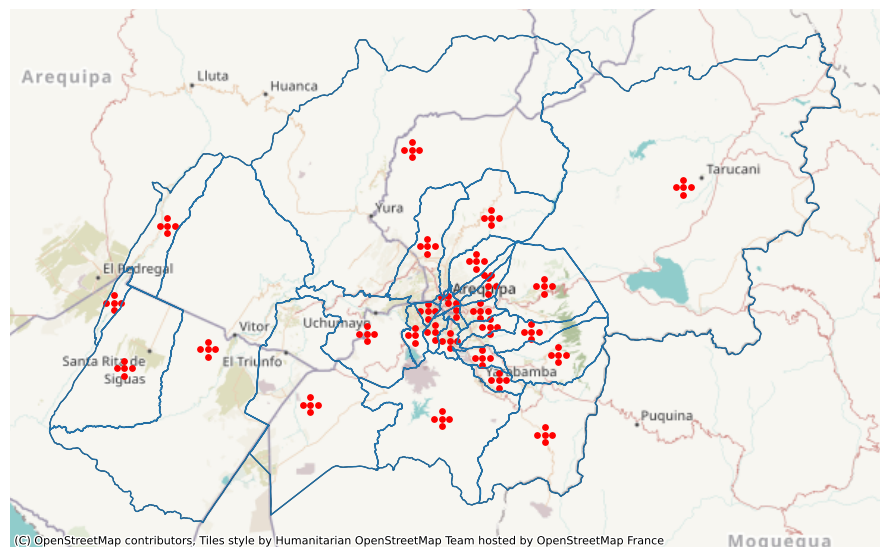

In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as cx

gdfs = []
for q in districts:
    gd = ox.geocode_to_gdf(q)[["geometry"]].copy()
    gd["distrito"] = q.split(",")[0]  # nombre corto
    gdfs.append(gd)

gdf_distritos = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="EPSG:4326")

# Convert points to dataframe
df_pts = pd.DataFrame(full_points)
gdf_pts = gpd.GeoDataFrame(
    df_pts,
    geometry=[Point(lon, lat) for lat, lon in zip(df_pts["lat"], df_pts["lon"])],
    crs="EPSG:4326",
)

# Graph districs
gdf_distritos_3857 = gdf_distritos.to_crs(3857)
gdf_pts_3857 = gdf_pts.to_crs(3857)

ax = gdf_distritos_3857.boundary.plot(linewidth=1.0, alpha=0.9, figsize=(9, 9))
gdf_distritos_3857.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.8)

# Points
gdf_pts_3857.plot(ax=ax, markersize=15, color="red")

# Add map for Arequipa(Provincia)
cx.add_basemap(ax, crs=gdf_distritos_3857.crs)

# Plot
ax.set_axis_off()
plt.tight_layout()
plt.show()
